# Quantized SNN for N-MNIST

In [1]:
# SNN
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch.functional import quant
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

# Quantization
import brevitas.nn as qnn

# Torch
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Tonic
import tonic
from tonic import DiskCachedDataset
from tonic import MemoryCachedDataset

# Other
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import pyfenrir as fenrir

In [2]:
sensor_size = tonic.datasets.NMNIST.sensor_size
batch_size = 128
n_timesteps = 100

def pad_time_dimension(frames, fixed_time_steps=100):
    """
    Pad or truncate the time dimension of frames to a fixed number of time steps.
    Input: frames [time, channels, height, width] (numpy or tensor)
    Output: frames [fixed_time_steps, channels, height, width] (tensor)
    """
    # Convert to tensor if input is numpy array
    if isinstance(frames, np.ndarray):
        frames = torch.tensor(frames, dtype=torch.float)
    current_time_steps = frames.shape[0]
    #print(f"Current time steps: {current_time_steps}, Fixed time steps: {fixed_time_steps}")
    if current_time_steps > fixed_time_steps:
        return frames[:fixed_time_steps]
    elif current_time_steps < fixed_time_steps:
        return torch.nn.functional.pad(frames, (0, 0, 0, 0, 0, 0, 0, fixed_time_steps - current_time_steps))
    return frames

frame_transform = transforms.Compose([
    tonic.transforms.Downsample(spatial_factor=16/34),                                  # Downscale 34×34 to 16×16
    tonic.transforms.ToFrame(sensor_size=(16, 16, 2), time_window=1000),                # Convert to frames, 10ms bins
    transforms.Lambda(lambda x: pad_time_dimension(x, fixed_time_steps=n_timesteps)),   # Pad/truncate time dimension
    transforms.Lambda(lambda x: torch.clamp(torch.tensor(x), 0, 1).type(torch.float)),  # Clamp spikes accumulted over time to (0,1)
    transforms.Lambda(lambda x: x[:, 1, :, :]  ),                                       # Select only ON channel
    transforms.Lambda(lambda x: x.flatten(start_dim=1)),  
])

# Load the dataset
trainset = tonic.datasets.NMNIST(save_to='../data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='../data', transform=frame_transform, train=False)

cached_trainset = MemoryCachedDataset(trainset)
cached_testset = MemoryCachedDataset(testset)

# Define your dataloaders...
trainloader = DataLoader(cached_trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [3]:
config = {
    "num_epochs": 1,       # Number of epochs to train for (per trial)
    "batch_size": batch_size,      # Batch size
    "seed": 0,              # Random seed
    
    # Quantization
    "num_bits": 4,          # Bit resolution
    
    # Network parameters
    "grad_clip": False,     # Whether or not to clip gradients
    "weight_clip": False,   # Whether or not to clip weights
    "batch_norm": True,     # Whether or not to use batch normalization
    "dropout": 0.07,        # Dropout rate
    "beta": 1.0,           # Decay rate parameter (beta)
    "threshold": 10,        # Threshold parameter (theta)
    "lr": 3.0e-3,           # Initial learning rate
    "slope": 5.6,           # Slope value (k)
    
    # Fixed params
    "num_steps": 100,       # Number of timesteps to encode input for
    "correct_rate": 0.8,    # Correct rate
    "incorrect_rate": 0.2,  # Incorrect rate
    "betas": (0.9, 0.999),  # Adam optimizer beta values
    "t_0": 4690,            # Initial frequency of the cosine annealing scheduler
    "eta_min": 0,           # Minimum learning rate
}

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_bits   = config["num_bits"]
        self.thr        = config["threshold"]
        self.slope      = config["slope"]
        self.num_steps  = config["num_steps"]
        self.batch_norm = config["batch_norm"]
        
        self.beta1 = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)

        # Input layer (16x16 = 256)
        self.fc1        = qnn.QuantLinear(16*16, 10, bias=False, weight_bit_width=4)
        self.lif1       = snn.Leaky(beta=1.0, threshold=1.0, learn_threshold=True, reset_mechanism='zero', reset_delay=False)

    def _beta_clamp(self, mem, beta):
        mem = torch.where(
            mem > 0,
            torch.clamp(mem - torch.abs(beta), min=0.0),
            mem
        )
        mem = torch.where(
            mem < 0,
            torch.clamp(mem + torch.abs(beta), max=0.0),
            mem
        )
        return mem

    def _mem_clamp(self, mem, scale, multiplier, bits=12):
        max_val = (2**(bits - 1)) - 1
        max_val = max_val * scale / multiplier
        min_val = -(2**(bits - 1)) - 1
        min_val = min_val * scale / multiplier

        mem = torch.clamp(mem, min=min_val, max=max_val)

        return mem

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        
        # Record all layers for debugging
        spk_rec1 = []
        mem_rec1 = []

        scale_fc1 = self.fc1.quant_weight().scale

        for step in range(self.num_steps):
            cur1 = self.fc1(x[:, step, :])
            mem1 = self._mem_clamp(mem1, scale_fc1, multiplier=10)
            spk1, mem1 = self.lif1(cur1, mem1)
            mem1 = self._beta_clamp(mem1, self.beta1)

            spk_rec1.append(spk1)
            mem_rec1.append(mem1)
        
        return torch.stack(spk_rec1), torch.stack(mem_rec1)

net = Net(config).to(device)

In [5]:
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=config["lr"],
    betas=config["betas"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["t_0"],
    eta_min=config["eta_min"],
    last_epoch=-1
)

criterion = SF.mse_count_loss(
    correct_rate=config["correct_rate"],
    incorrect_rate=config["incorrect_rate"]
)

=======Training Network=======


Training:   0%|          | 0/469 [00:00<?, ?it/s]C:\Users\andre\AppData\Local\Temp\ipykernel_13376\2737539726.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.Lambda(lambda x: torch.clamp(torch.tensor(x), 0, 1).type(torch.float)),  # Clamp spikes accumulted over time to (0,1)
c:\home\university\8-semester\fenrir\python\.venv\Lib\site-packages\torch\_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/core/TensorImpl.h:1938.)
  return super().rename(names)
c:\home\university\8-semester\fenrir\python\.venv\Lib\site-packages\brevitas\nn\quant_linear.py:69: UserWarning: Defining your `__torch_functio

Epoch: 0 	Test Accuracy: 80.7


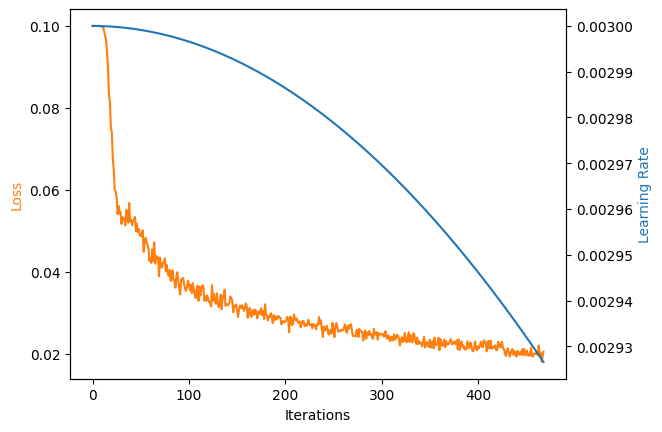

In [6]:
def train(config, net, trainloader, criterion, optimizer, device="cpu", scheduler=None):
    """
    Complete one epoch of training.
    """
    
    net.train()
    loss_accum = []
    lr_accum = []

    for batch_idx, (data, labels) in enumerate(tqdm(trainloader, leave=False, desc="Training")):
        data, labels = data.to(device), labels.to(device)
        spk_rec, _ = net(data)
        loss = criterion(spk_rec, labels)
        optimizer.zero_grad()
        loss.backward()

        ## Enable gradient clipping
        if config["grad_clip"]:
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        ## Enable weight clipping
        if config["weight_clip"]:
            with torch.no_grad():
                for param in net.parameters():
                    param.clamp_(-1, 1)

        optimizer.step()
        scheduler.step()
        loss_accum.append(loss.item() / config["num_steps"])
        lr_accum.append(optimizer.param_groups[0]["lr"])

    return loss_accum, lr_accum

def test(config, net, testloader, device="cpu"):
    """
    Calculate accuracy on full test set.
    """

    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, _ = net(images)
            accuracy = SF.accuracy_rate(outputs, labels)
            total += labels.size(0)
            correct += accuracy * labels.size(0)

    return 100 * correct / total

loss_list = []
lr_list = []

## Load model instead of training
load_model = False
if load_model:
    net.load_state_dict(torch.load('models/../nmnist_1layer.pth'))
else:
    print(f"=======Training Network=======")
    for epoch in range(config['num_epochs']):
        loss, lr  = train(config, net, trainloader, criterion, optimizer, device, scheduler)
        loss_list = loss_list + loss
        lr_list   = lr_list + lr
        # Test
        test_accuracy = test(config, net, testloader, device)
        print(f"Epoch: {epoch} \tTest Accuracy: {test_accuracy}")

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_list, color='tab:orange')
    ax2.plot(lr_list, color='tab:blue')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss', color='tab:orange')
    ax2.set_ylabel('Learning Rate', color='tab:blue')
    plt.show()

In [7]:
save_model = True
if save_model:
    dir = "../models"
    if not os.path.exists(dir):
        os.makedirs(dir)
    torch.save(net.state_dict(), f"{dir}/nmnist_1layer.pth")

C:\Users\andre\AppData\Local\Temp\ipykernel_13376\2737539726.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.Lambda(lambda x: torch.clamp(torch.tensor(x), 0, 1).type(torch.float)),  # Clamp spikes accumulted over time to (0,1)


torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
Spike counts per neuron: [24.0, 18.0, 11.0, 36.0, 28.0, 27.0, 32.0, 19.0, 25.0, 23.0]
Average spikes per neuron: 24.30000114440918


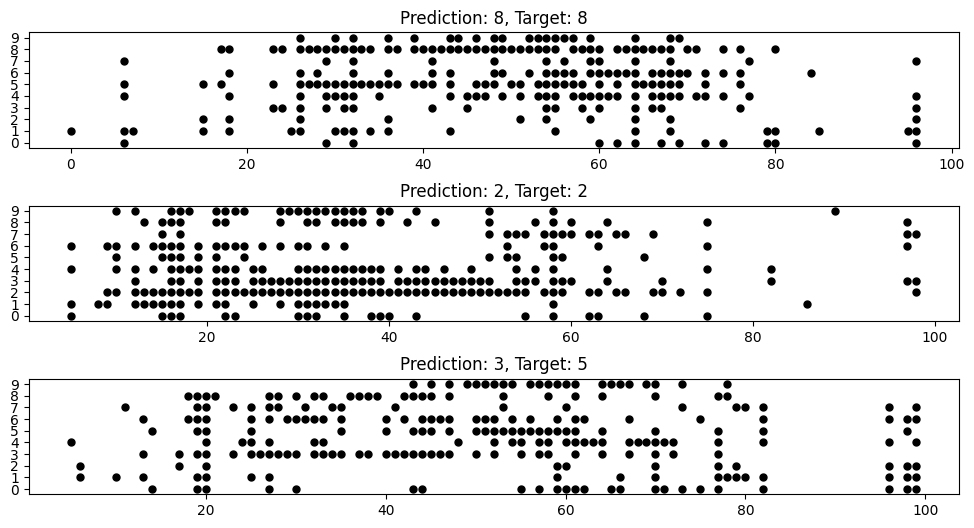

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
iter_test = iter(testloader)
data_it, targets_it = next(iter_test)

dataset = testloader.dataset
num_samples = len(dataset)
ran_idx = torch.randint(0, num_samples, (3,))

for i, idx in enumerate(ran_idx):
    # Get some data
    spike_data, target = dataset[idx]
    spike_data = spike_data.unsqueeze(0)
    spike_data = spike_data.to(device)

    # Forward pass
    print(spike_data.shape)
    spk_rec, mem_rec = net(spike_data)

    # Besværgelse (just summing the spikes)
    pred = torch.argmax(spk_rec.sum(dim=0).squeeze()).item()

    # Plot
    splt.raster(spk_rec[:, 0].view(100, -1), ax[i], s=25, c="black")
    ax[i].set_yticks(np.arange(0, 10, 1))
    ax[i].set_title(f"Prediction: {pred}, Target: {target}")

plt.subplots_adjust(hspace=0.5)

spike_sums = spk_rec.sum(dim=0).squeeze()  # shape: [10]
spike_avg = spike_sums.sum(dim=0)/10

print(f"Spike counts per neuron: {spike_sums.tolist()}")
print(f"Average spikes per neuron: {spike_avg.tolist()}")

In [16]:
spike_data.shape

torch.Size([1, 100, 256])

In [19]:
exp_data    = spike_data[0, :, :]
tsteps      = exp_data.shape[0]
events      = []
tstep_event_idx = []

for t in range(0, tsteps):
    t_data = exp_data[t, :]
    non_zero_indices = (t_data != 0).nonzero(as_tuple=True)[0]

    for idx in non_zero_indices.tolist():
        events.append(idx)

    events.append(0b1000000000000)

    tstep_event_idx.append(len(events))

binary_events = [format(idx, '010b') for idx in events]

out_file = 'nmnist_fpga.txt'
with open(out_file, 'w', encoding='utf-8') as f:
    for b in binary_events:
        if not b == '1000000000000':
            f.write("000" + b + '\n')
        else:
            f.write(b + '\n')

In [ ]:
exp_data = spike_data[0, :, :]
tsteps = exp_data.shape[0]
events = []
tstep_event_idx = []

for t in range(tsteps):
    t_data = exp_data[t, :]
    non_zero_indices = (t_data != 0).nonzero(as_tuple=True)[0]

    for idx in non_zero_indices.tolist():
        events.append(idx)

    events.append(0b1000000000000)  # marker

    tstep_event_idx.append(len(events))

# Create a C header file with the events as an array
header_file = 'nmnist_fpga_data.h'

with open(header_file, 'w', encoding='utf-8') as f:
    f.write('#ifndef NMNIST_FPGA_DATA_H\n')
    f.write('#define NMNIST_FPGA_DATA_H\n\n')

    # Write array size
    f.write(f'#define NMNIST_EVENTS_SIZE {len(events)}\n\n')

    # Write the array data
    f.write('const unsigned int nmnist_events[NMNIST_EVENTS_SIZE] = {\n')

    # Write values as hex or binary, here hex is easier for C
    for i, val in enumerate(events):
        # Write comma except last element
        comma = ',' if i < len(events) - 1 else ''
        f.write(f'    0x{val:X}{comma}\n')

    f.write('};\n\n')
    f.write('#endif // NMNIST_FPGA_DATA_H\n')


In [10]:
fenrir.export_weights(net.fc1, 40, 256, '../../src/design_sources/data/fc1_syn.data')
quant_scale = net.fc1.quant_weight().scale
beta        = net.beta1/net.fc1.quant_weight().scale
thr         = fenrir.get_threshold(net.fc1, net.lif1)
print(f"Quant Scale: {quant_scale}")
print(f"Beta: {beta}")
print(f"Threshold: {thr}")

Quant Scale: 0.08426179736852646
Beta: 23.052433013916016
Threshold: 6.706425189971924


In [ ]:
fenrir.export_weights(net.fc2, 32, 256, '../src/design_sources/data/fc2_syn.data')
quant_scale = net.fc2.quant_weight().scale
beta        = net.beta2/net.fc2.quant_weight().scale
thr         = fenrir.get_threshold(net.fc2, net.lif2)
print(f"Quant Scale: {quant_scale}")
print(f"Beta: {beta}")
print(f"Threshold: {thr}")

In [ ]:
fenrir.export_weights(net.fc3, 40, 128, '../src/design_sources/data/fc3_syn.data')
quant_scale = net.fc3.quant_weight().scale
beta        = net.beta3/net.fc3.quant_weight().scale
thr         = fenrir.get_threshold(net.fc3, net.lif3)
print(f"Quant Scale: {quant_scale}")
print(f"Beta: {beta}")
print(f"Threshold: {thr}")

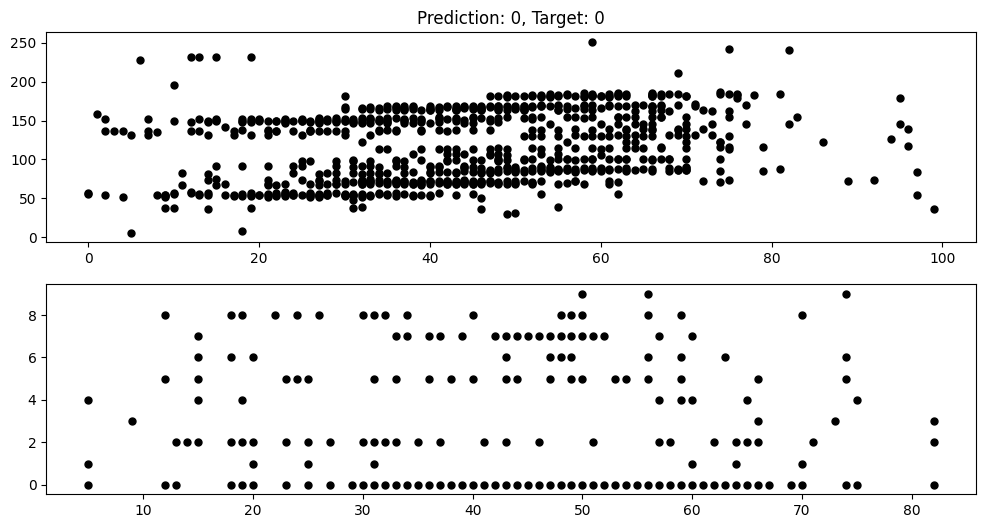

In [14]:
## Select a datapoint from the dataset
dataset = testloader.dataset
spike_data, target_tmp = dataset[6]

## Spike encode it
spike_data = spike_data.unsqueeze(0)
spike_data = spike_data.to(device)

## Forward pass
spk_rec1, mem_rec1 = net(spike_data)
pred = torch.argmax(spk_rec1.sum(dim=0).squeeze()).item()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
splt.raster(spike_data[0, :, :].view(100, -1), ax[0], s=25, c="black")
splt.raster(spk_rec1[:, 0].view(100, -1), ax[1], s=25, c="black")
ax[0].set_title(f"Prediction: {pred}, Target: {target_tmp}")

## Detach as we will use these for comparison with the testbench
spk_rec1 = spk_rec1.cpu().detach().numpy()
mem_rec1 = mem_rec1.cpu().detach().numpy()

In [ ]:
weights = net.fc2.quant_weight()/net.fc2.quant_weight().scale
weights = weights.cpu().detach().numpy()

in_nrns = [7, 0]
weights = weights[11, nrn_events]

weights_sum = weights.sum()

print(weights)
print(weights_sum)

In [ ]:
sum = 0
idx = 0
for e, w in zip(nrn_events, weights):
    sum += w
    print(f"idx: {idx}, \tEvent: {e},\tWeight: {w},\tMem: {sum}")
    idx += 1

In [ ]:
## See spikes
t = 53

spk_rec = spk_rec1

spk_events = []
nrn_events = []
for nrn in range(0, spk_rec.shape[2]):
    spk_events.append(spk_rec[t, 0, nrn])

for nrn_index, has_spike in enumerate(spk_events):
    if has_spike > 0:
        nrn_events.append(nrn_index)
        print(f"  Neuron {nrn_index}:\t {has_spike}")

In [ ]:
## Extract input events for specific time index
t_events = []

tstep_data = spike_data[0, :, :]
tstep_data = tstep_data.view(100, -1).cpu().detach().numpy()

for tstep in range(0, 100):
    temp = tstep_data[tstep, :]
    non_zero_indices = np.nonzero(temp)[0]
    t_events.append(non_zero_indices.tolist())

print(t_events[9])

In [ ]:
exp_data    = spike_data[0, :, :]
tsteps      = exp_data.shape[0]
events      = []
tstep_event_idx = []

for t in range(0, tsteps):
    t_data = exp_data[t, :]
    non_zero_indices = (t_data != 0).nonzero(as_tuple=True)[0]

    for idx in non_zero_indices.tolist():
        events.append(idx)

    events.append(0b1000000000000)

    tstep_event_idx.append(len(events))

binary_events = [format(idx, '010b') for idx in events]

out_file = 'nmnist_data.txt'
with open(out_file, 'w', encoding='utf-8') as f:
    for b in binary_events:
        if not b == '1000000000000':
            f.write("000" + b + '\n')
        else:
            f.write(b + '\n')

In [ ]:
max_val = (2**(12 - 1)) - 1
min_val = -(2**(12 - 1)) - 1
max_val = max_val/10
min_val = min_val/10

for nrn in range(mem_rec2.shape[2]):
    mem = mem_rec2[:, 0, nrn]/net.fc2.quant_weight().scale.cpu().detach()
    if (mem <= min_val + 40).any():
        for t in range(100):
            if mem_rec2[t, 0, nrn]/net.fc2.quant_weight().scale.cpu().detach() <= min_val + 40:
                print(f"Min: {nrn}")
                print(f"t: {t}")
                break
    if (mem >= max_val-10).any():
        for t in range(100):
            if mem_rec2[t, 0, nrn]/net.fc2.quant_weight().scale.cpu().detach() >= max_val:
                print(f"Max: {nrn}")
                print(f"t: {t}")
                break

In [ ]:
def bin_to_signed_int(bstr, bits=12):
    """Convert binary string to signed integer."""
    val = int(bstr, 2)
    if val >= 2**(bits - 1):
        val -= 2**bits
    return val

names = ['t', 'nrn_addr', 'val']
df_mem = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/mem_rec1.csv', names=names)

nrn_mem = {str(i): [] for i in range(256)} # Changed to 256

for t in range(1, 101):
    subset = df_mem[df_mem['t'] == t][['nrn_addr', 'val']].head(6)
    val_list = subset['val'].tolist()

    for i, val_str in enumerate(val_list):
        base_index = i * 3
        nrn_mem[str(base_index + 2)].append(bin_to_signed_int(val_str[0:12], bits=12))
        nrn_mem[str(base_index + 1)].append(bin_to_signed_int(val_str[12:24], bits=12))
        nrn_mem[str(base_index)].append(bin_to_signed_int(val_str[24:36], bits=12))

names = ['t', 'nrn_addr']
df_spk = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/spk_rec1.csv', names=names)
df_spk['nrn_addr'] = df_spk['nrn_addr'].apply(lambda b: int(str(b), 2))

x = np.arange(100)
spks = np.zeros((256, len(x)))
for t, nrn_addr in zip(df_spk['t'], df_spk['nrn_addr']):
    if nrn_addr < 256 and t < 100:
        spks[nrn_addr, t-1] = 1


nrn = 9
sum_fenrir   = spks[nrn].sum()
sum_snntorch = spk_rec1[:, 0, nrn].sum()
print(f"Fenrir spike sum: {sum_fenrir}")
print(f"snntorch spike sum: {sum_snntorch}")

multiplier = 10
scale = net.fc1.quant_weight().scale.cpu().detach().numpy()
thr = fenrir.get_threshold(net.fc1, net.lif1)*multiplier

x_start = 0
x_end   = 100

fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].plot(x, nrn_mem[f"{nrn}"], color='red', linewidth=2, alpha=0.5, label="TB")
ax[0].plot(mem_rec1[:, 0, nrn]*multiplier/scale, linestyle='--', color='blue', linewidth=2, alpha=0.5, label="snntorch")
ax[0].plot(x, np.full_like(x, thr), linestyle='--', color='black', label="Thr")
ax[0].plot(x, np.full_like(x, 0), linestyle=':', color='black', alpha=0.5)
ax[1].plot(x, spks[nrn], color='red', linewidth=2, alpha=0.5)
ax[1].plot(x, spk_rec1[:, 0, nrn], linestyle='--', color='blue', linewidth=2, alpha=0.5)
ax[0].set_title("mem_rec")
ax[1].set_title("spk_rec")

for a in ax:
    a.set_xlim(x_start, x_end)
    a.set_xticks(np.arange(x_start, x_end + 1, 10))
    a.legend(loc="upper right")

fig.suptitle(f"Layer 1, Neuron {nrn}")
fig.tight_layout()

In [ ]:
def bin_to_signed_int(bstr, bits=12):
    """Convert binary string to signed integer."""
    val = int(bstr, 2)
    if val >= 2**(bits - 1):
        val -= 2**bits
    return val

names = ['t', 'nrn_addr', 'val']
df_mem = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/mem_rec2.csv', names=names)

nrn_mem = {str(i) : [] for i in range(18)}

for t in range(1, 100):
    subset = df_mem[df_mem['t'] == t][['nrn_addr', 'val']].head(6)
    val_list = subset['val'].tolist()

    nrn_mem['2'].append(bin_to_signed_int(val_list[0][0:12], bits=12))
    nrn_mem['1'].append(bin_to_signed_int(val_list[0][12:24], bits=12))
    nrn_mem['0'].append(bin_to_signed_int(val_list[0][24:36], bits=12))
    nrn_mem['5'].append(bin_to_signed_int(val_list[1][0:12], bits=12))
    nrn_mem['4'].append(bin_to_signed_int(val_list[1][12:24], bits=12))
    nrn_mem['3'].append(bin_to_signed_int(val_list[1][24:36], bits=12))
    nrn_mem['8'].append(bin_to_signed_int(val_list[2][0:12], bits=12))
    nrn_mem['7'].append(bin_to_signed_int(val_list[2][12:24], bits=12))
    nrn_mem['6'].append(bin_to_signed_int(val_list[2][24:36], bits=12))
    nrn_mem['11'].append(bin_to_signed_int(val_list[3][0:12], bits=12))
    nrn_mem['10'].append(bin_to_signed_int(val_list[3][12:24], bits=12))
    nrn_mem['9'].append(bin_to_signed_int(val_list[3][24:36], bits=12))
    nrn_mem['14'].append(bin_to_signed_int(val_list[4][0:12], bits=12))
    nrn_mem['13'].append(bin_to_signed_int(val_list[4][12:24], bits=12))
    nrn_mem['12'].append(bin_to_signed_int(val_list[4][24:36], bits=12))
    nrn_mem['17'].append(bin_to_signed_int(val_list[5][0:12], bits=12))
    nrn_mem['16'].append(bin_to_signed_int(val_list[5][12:24], bits=12))
    nrn_mem['15'].append(bin_to_signed_int(val_list[5][24:36], bits=12))


names = ['t', 'nrn_addr']
df_spk = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/spk_rec2.csv', names=names)
df_spk['nrn_addr'] = df_spk['nrn_addr'].apply(lambda b: int(str(b), 2))

x = np.arange(99)
spks = np.zeros((18, len(x)))
for t, nrn_addr in zip(df_spk['t'], df_spk['nrn_addr']):
    if nrn_addr < 18 and t < 99:
        spks[nrn_addr, t-2] = 1

nrn = 10
sum_fenrir   = spks[nrn].sum()
sum_snntorch = spk_rec2[:, 0, nrn].sum()
print(f"Fenrir spike sum: {sum_fenrir}")
print(f"snntorch spike sum: {sum_snntorch}")

multiplier = 10
scale = net.fc2.quant_weight().scale.cpu().detach().numpy()
thr = fenrir.get_threshold(net.fc2, net.lif2)*multiplier

x_start = 50
x_end   = 60

fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].plot(x, nrn_mem[f"{nrn}"], color='red', linewidth=2, alpha=0.5, label="TB")
ax[0].plot(mem_rec2[:99, 0, nrn]*multiplier/scale, linestyle='--', color='blue', linewidth=2, alpha=0.5, label="snntorch")
ax[0].plot(x, np.full_like(x, thr), linestyle='--', color='black', label="Thr")
ax[0].plot(x, np.full_like(x, 0), linestyle=':', color='black', alpha=0.5)
ax[1].plot(x, spks[nrn], color='red', linewidth=2, alpha=0.5)
ax[1].plot(x, spk_rec2[:99, 0, nrn], linestyle='--', color='blue', linewidth=2, alpha=0.5)
ax[0].set_title("mem_rec")
ax[1].set_title("spk_rec")

for a in ax:
    a.set_xlim(x_start, x_end)
    a.set_xticks(np.arange(x_start, x_end + 1, 1))
    a.legend(loc="upper right")

fig.suptitle(f"Layer 2, Neuron {nrn}")
fig.tight_layout()

In [ ]:
def bin_to_signed_int(bstr, bits=12):
    """Convert binary string to signed integer."""
    val = int(bstr, 2)
    if val >= 2**(bits - 1):
        val -= 2**bits
    return val

names = ['t', 'nrn_addr', 'val']
df_mem = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/mem_rec3.csv', names=names)

nrn_mem = {str(i) : [] for i in range(10)}

for t in range(1, 100):
    subset = df_mem[df_mem['t'] == t][['nrn_addr', 'val']].head(4)
    val_list = subset['val'].tolist()

    nrn_mem['2'].append(bin_to_signed_int(val_list[0][0:12], bits=12))
    nrn_mem['1'].append(bin_to_signed_int(val_list[0][12:24], bits=12))
    nrn_mem['0'].append(bin_to_signed_int(val_list[0][24:36], bits=12))
    nrn_mem['5'].append(bin_to_signed_int(val_list[1][0:12], bits=12))
    nrn_mem['4'].append(bin_to_signed_int(val_list[1][12:24], bits=12))
    nrn_mem['3'].append(bin_to_signed_int(val_list[1][24:36], bits=12))
    nrn_mem['8'].append(bin_to_signed_int(val_list[2][0:12], bits=12))
    nrn_mem['7'].append(bin_to_signed_int(val_list[2][12:24], bits=12))
    nrn_mem['6'].append(bin_to_signed_int(val_list[2][24:36], bits=12))
    nrn_mem['9'].append(bin_to_signed_int(val_list[3][24:36], bits=12))

names = ['t', 'nrn_addr']
df_spk = pd.read_csv('../vivado/fenrir/fenrir.sim/sim_1/behav/xsim/spk_rec3.csv', names=names)
df_spk['nrn_addr'] = df_spk['nrn_addr'].apply(lambda b: int(str(b), 2))

x = np.arange(99)
spks = np.zeros((10, len(x)))
for t, nrn_addr in zip(df_spk['t'], df_spk['nrn_addr']):
    if nrn_addr < 10 and t < 99:
        spks[nrn_addr, t-3] = 1

nrn = 0
sum_fenrir   = spks[nrn].sum()
sum_snntorch = spk_rec3[:, 0, nrn].sum()
print(f"Fenrir spike sum: {sum_fenrir}")
print(f"snntorch spike sum: {sum_snntorch}")

multiplier = 10
scale = net.fc3.quant_weight().scale.cpu().detach().numpy()
thr = fenrir.get_threshold(net.fc3, net.lif3)*multiplier

x_start = 0
x_end   = 100

fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].plot(x, nrn_mem[f"{nrn}"], color='red', linewidth=2, alpha=0.5, label="TB")
ax[0].plot(mem_rec3[:99, 0, nrn]*multiplier/scale, linestyle='--', color='blue', linewidth=2, alpha=0.5, label="snntorch")
ax[0].plot(x, np.full_like(x, thr), linestyle='--', color='black', label="Thr")
ax[0].plot(x, np.full_like(x, 0), linestyle=':', color='black', alpha=0.5)
ax[1].plot(x, spks[nrn], color='red', linewidth=2, alpha=0.5)
ax[1].plot(x, spk_rec3[:99, 0, nrn], linestyle='--', color='blue', linewidth=2, alpha=0.5)
ax[0].set_title("mem_rec")
ax[1].set_title("spk_rec")

for a in ax:
    a.set_xlim(x_start, x_end)
    a.set_xticks(np.arange(x_start, x_end + 1, 10))
    a.legend(loc="upper right")

fig.suptitle(f"Layer 3, Neuron {nrn}")
fig.tight_layout()